In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_image(path, img_transform, size = (300,300)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)

def get_gram(m):
    _, c, h, w = m.size()
    m = m.view(c, h * w)
    m = torch.mm(m, m.t()) 
    return m

def denormalize_img(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22]
        self.vgg = models.vgg16(pretrained=True).features
        
    def forward(self, x):
        layer_features = []
        for layer_number, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_number) in self.selected_layers:
                layer_features.append(x)
        return layer_features

img_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])

content_img = get_image('/content/drive/MyDrive/NeuralStyleTransfer/content2.jpg', img_transform)
style_img = get_image('/content/drive/MyDrive/NeuralStyleTransfer/style.jpg', img_transform)
generated_img = content_img.clone()    
generated_img.requires_grad = True

optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor().to(device)

for p in encoder.parameters():
    p.requires_grad = False


content_weight = 1
style_weight = 100

for epoch in range(10000):
    
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)
    
    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)  

    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        style_loss += torch.mean((gram_gf - gram_sf)**2)  / (c * h * w) 

    loss = content_weight * content_loss + style_weight * style_loss 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print ('Epoch [{}]\tContent Loss: {:.4f}\tStyle Loss: {:.4f}'.format(epoch, content_loss.item(), style_loss.item()))


Epoch [0]	Content Loss: 0.0000	Style Loss: 2833.2214
Epoch [10]	Content Loss: 0.3419	Style Loss: 2372.5715
Epoch [20]	Content Loss: 0.9687	Style Loss: 1998.5576
Epoch [30]	Content Loss: 1.4493	Style Loss: 1706.9456
Epoch [40]	Content Loss: 1.7888	Style Loss: 1478.2432
Epoch [50]	Content Loss: 2.0413	Style Loss: 1294.7495
Epoch [60]	Content Loss: 2.2445	Style Loss: 1144.4086
Epoch [70]	Content Loss: 2.4095	Style Loss: 1018.9531
Epoch [80]	Content Loss: 2.5493	Style Loss: 912.5732
Epoch [90]	Content Loss: 2.6669	Style Loss: 821.1127
Epoch [100]	Content Loss: 2.7670	Style Loss: 741.6964
Epoch [110]	Content Loss: 2.8524	Style Loss: 672.0681
Epoch [120]	Content Loss: 2.9282	Style Loss: 610.5839
Epoch [130]	Content Loss: 2.9960	Style Loss: 556.0584
Epoch [140]	Content Loss: 3.0576	Style Loss: 507.6525
Epoch [150]	Content Loss: 3.1134	Style Loss: 464.6705
Epoch [160]	Content Loss: 3.1646	Style Loss: 426.5434
Epoch [170]	Content Loss: 3.2099	Style Loss: 392.8598
Epoch [180]	Content Loss: 3.252

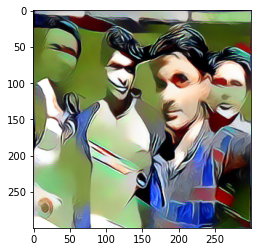

In [17]:
inp = generated_img.detach().cpu().squeeze()
inp = denormalize_img(inp)
plt.imshow(inp)